# <center> Assignment 2 - Computer Vision ENCS5343


### This assignment achieve to implement Content-Based Image Retrieval (CBIR) using various image representations in order to compare between them, observe the results of each method, measure the efficiency of each method using metrics (Precision, Recall, AUC, F1-Score, ....)
#### Steps: 
1. Data processing (uploading images and getting them ready).
2. Choose an image representation technique.
3. Apply the CBIR on 15 different queries and measure the preformace using different measure metrics.
4. Observe the results depending with their rankings.
5. Compare between the techniques.

### Step 0: Import important packages and libraries.

In [41]:
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt
import os
import numpy as np
import time
from sklearn.metrics import auc, roc_curve

### Step 1: Upload and store the data.

In [3]:
def upload_and_store_images(dataset_filepath):
    images = []
    for filename in sorted(os.listdir(path=dataset_filepath)):
        image_path = os.path.join(dataset_filepath, filename)
        if os.path.isfile(image_path):
            try: 
                images.append(Image.open(image_path))
            except:
                print("Failed to upload image: {image_path}")
    return images
images = upload_and_store_images('./dataset')

In [4]:
images[0].height

384

### Step 2: Choose an image representation technique.

#### A. Color Histogram

In [43]:
def calculate_color_histogram(images, number_of_bins):
    color = ('b', 'g', 'r')
    histograms = []
    for i in range(len(images)):
        histograms.append([])
        total_pixels = images[i].height * images[i].width
        img = np.array(images[i])[:, :, ::-1].copy()
        for i in range(len(color)):
            histograms[-1].append(cv.calcHist([img], [i], None, [number_of_bins], [0,256]) / total_pixels)
    return np.array(histograms)

#### Step 3 for Color Histogram: Apply CBIR on different random 15 query images

In [15]:
def calculate_distance(hist1, hist2):
    return np.linalg.norm(hist1 -hist2)

In [25]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [34]:
def distance_to_probability(distance):
    return np.exp(-distance)

def calculate_probabilities(index_query_image, images, histogram):
    probabilities = []
    for i, image in enumerate(images):
        distance = np.linalg.norm(histogram[index_query_image] - histogram[i])
        probabilities.append([image, distance_to_probability(distance), classes[i // 100]])
    probabilities.sort(key=lambda x: x[1], reverse=True)
    return probabilities


In [35]:
def retrieve_similar_images_using_hist(images, bins, threshold):
    global classes
    query_images_idxs = []
    query_images_classes = []
    query_images_similar_images = []
    query_images_similar_images_classes = []
    query_images_similar_images_probabilities = []
    for i in range(15):
        random_idx = np.random.randint(0, 1000)
        query_images_idxs.append(random_idx)
        query_images_classes.append(classes[random_idx // 100])
        probabilities = calculate_probabilities(random_idx, images, histogram=calculate_color_histogram(images, bins))
        query_images_similar_images.append([probability[0] for probability in probabilities if probability[1] >= threshold])
        query_images_similar_images_probabilities.append([probability[1] for probability in probabilities if probability[1] >= threshold])
        query_images_similar_images_classes.append([probability[2] for probability in probabilities if probability[1] >= threshold])
    return query_images_idxs, query_images_classes, query_images_similar_images, query_images_similar_images_classes, query_images_similar_images_probabilities

def compute_measures(query_image_class, retrieved_images_classes):
    true_positives = sum([1 for retrieved_image_class in retrieved_images_classes if retrieved_image_class == query_image_class])
    false_positives =  len(retrieved_images_classes) - true_positives
    false_negatives = 100 - true_positives
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f1_score = 2 / (1 / recall + 1 / precision)
    return f1_score, precision, recall



F1-score for the 120-bins experiment: 0.18581734364388264
Recall score for the 120-bins experiment: 0.9419999999999998
Precision score for the 120-bins experiment: 0.10307538437683875
AUC for the 120-bins experiment: 0.530816167728813
Time elapsed: 13.716362953186035


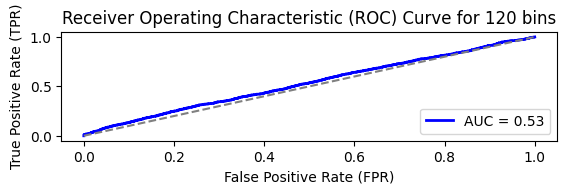

F1-score for the 180-bins experiment: 0.19501660432462556
Recall score for the 180-bins experiment: 0.9019999999999999
Precision score for the 180-bins experiment: 0.13038255498142798
AUC for the 180-bins experiment: 0.5439147106337698
Time elapsed: 12.947635650634766


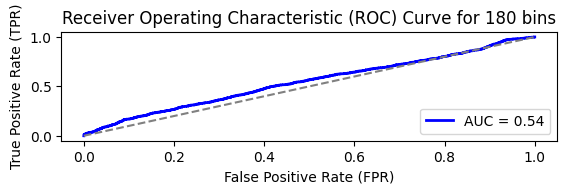

F1-score for the 360-bins experiment: 0.18392986838080178
Recall score for the 360-bins experiment: 0.9659999999999999
Precision score for the 360-bins experiment: 0.10165236637474856
AUC for the 360-bins experiment: 0.6008851625479628
Time elapsed: 14.032819271087646


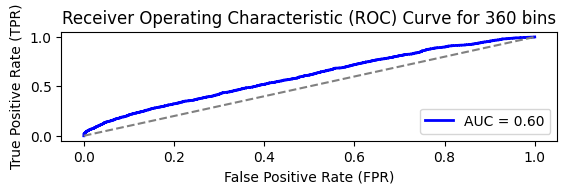

In [46]:

start_time_120_bins = time.time()
query_images_idxs_120, query_images_classes_120, query_images_similar_images_120, query_images_similar_images_classes_120, query_images_similar_images_probabilities_120 = retrieve_similar_images_using_hist(images, bins=120, threshold=0.5)
f1_score_120 = 0
recall_120 = 0
precision_120 = 0 
true_labels = []
predicted_probs = []
for i in range(len(query_images_idxs_120)):
    f1_score_i, precision_i, recall_i = compute_measures(query_images_classes_120[i], query_images_similar_images_classes_120[i])
    f1_score_120 += f1_score_i / len(query_images_idxs_120)
    recall_120 += recall_i / len(query_images_idxs_120)
    precision_120 += precision_i / len(query_images_idxs_120)
    true_labels += [1 if label == query_images_classes_120[i] else 0 for label in query_images_similar_images_classes_120[i]]
    predicted_probs += query_images_similar_images_probabilities_120[i]

end_time_120_bins = time.time()
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
auc_measure_120 = auc(fpr, tpr)
print(f"F1-score for the 120-bins experiment: {f1_score_120}")
print(f"Recall score for the 120-bins experiment: {recall_120}")
print(f"Precision score for the 120-bins experiment: {precision_120}")
print(f"AUC for the 120-bins experiment: {auc_measure_120}")
print(f"Time elapsed: {end_time_120_bins - start_time_120_bins}")
plt.subplot(3, 1, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_measure_120:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for 120 bins')
plt.legend(loc='lower right')
plt.show()

start_time_180_bins = time.time()
query_images_idxs_180, query_images_classes_180, query_images_similar_images_180, query_images_similar_images_classes_180, query_images_similar_images_probabilities_180 = retrieve_similar_images_using_hist(images, bins=180, threshold=0.5)
f1_score_180 = 0
recall_180 = 0
precision_180 = 0 
true_labels = []
predicted_probs = []
for i in range(len(query_images_idxs_180)):
    f1_score_i, precision_i, recall_i = compute_measures(query_images_classes_180[i], query_images_similar_images_classes_180[i])
    f1_score_180 += f1_score_i / len(query_images_idxs_180)
    recall_180 += recall_i / len(query_images_idxs_180)
    precision_180 += precision_i / len(query_images_idxs_180)
    true_labels += [1 if label == query_images_classes_180[i] else 0 for label in query_images_similar_images_classes_180[i]]
    predicted_probs += query_images_similar_images_probabilities_180[i]

end_time_180_bins = time.time()
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
auc_measure_180 = auc(fpr, tpr)

print(f"F1-score for the 180-bins experiment: {f1_score_180}")
print(f"Recall score for the 180-bins experiment: {recall_180}")
print(f"Precision score for the 180-bins experiment: {precision_180}")
print(f"AUC for the 180-bins experiment: {auc_measure_180}")
print(f"Time elapsed: {end_time_180_bins - start_time_180_bins}")
plt.subplot(3, 1, 2)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_measure_180:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for 180 bins')
plt.legend(loc='lower right')
plt.show()

start_time_360_bins = time.time()
query_images_idxs_360, query_images_classes_360, query_images_similar_images_360, query_images_similar_images_classes_360, query_images_similar_images_probabilities_360 = retrieve_similar_images_using_hist(images, bins=360, threshold=0.5)
f1_score_360 = 0
recall_360 = 0
precision_360 = 0 
true_labels = []
predicted_probs = []
for i in range(len(query_images_idxs_360)):
    f1_score_i, precision_i, recall_i = compute_measures(query_images_classes_360[i], query_images_similar_images_classes_360[i])
    f1_score_360 += f1_score_i / len(query_images_idxs_360)
    recall_360 += recall_i / len(query_images_idxs_360)
    precision_360 += precision_i / len(query_images_idxs_360)
    true_labels += [1 if label == query_images_classes_360[i] else 0 for label in query_images_similar_images_classes_360[i]]
    predicted_probs += query_images_similar_images_probabilities_360[i]

end_time_360_bins = time.time()
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
auc_measure_360 = auc(fpr, tpr)
print(f"F1-score for the 360-bins experiment: {f1_score_360}")
print(f"Recall score for the 360-bins experiment: {recall_360}")
print(f"Precision score for the 360-bins experiment: {precision_360}")
print(f"AUC for the 360-bins experiment: {auc_measure_360}")
print(f"Time elapsed: {end_time_360_bins - start_time_360_bins}")
plt.subplot(3, 1, 3)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_measure_360:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for 360 bins')
plt.legend(loc='lower right')
plt.show()


#### Step 4 for Color Histogram: Observe the results depending with their rankings (the most left is the one with the higest rank).

In [47]:
query_image_120 = images[query_images_idxs_120[0]]
query_image_180 = images[query_images_idxs_180[0]]
query_image_360 = images[query_images_idxs_360[0]]

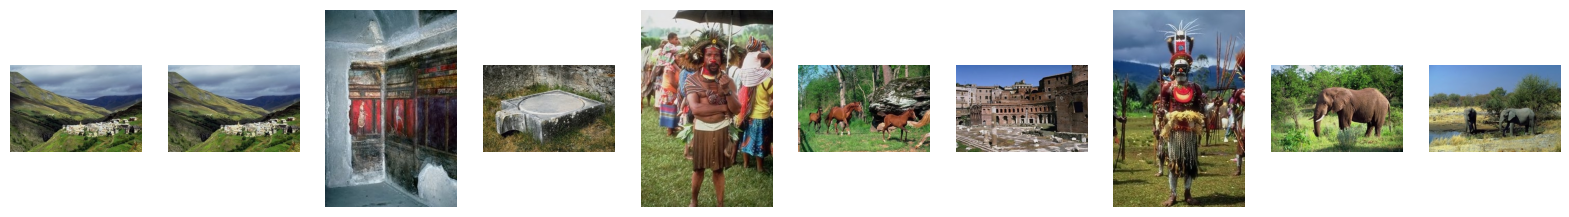

In [52]:
plt.figure(figsize=(20, 20))
for i, image in enumerate([query_image_120] + query_images_similar_images_120[0][:9]):
    plt.subplot(1, 10, 1 + i)
    plt.imshow(image)
    plt.axis('off')
plt.show()

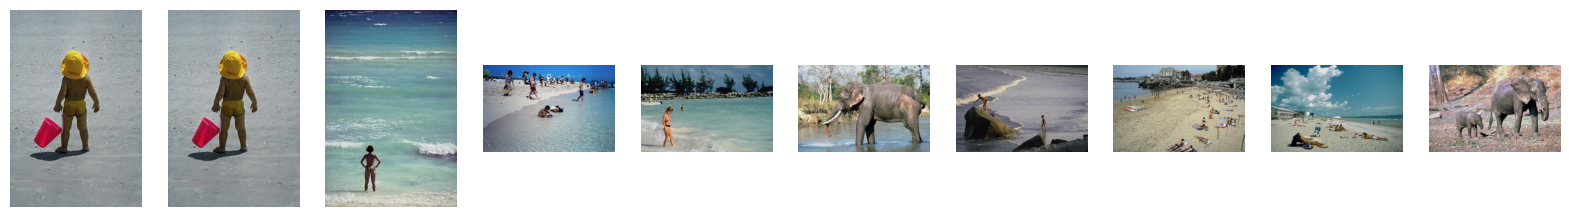

In [53]:
plt.figure(figsize=(20, 20))
for i, image in enumerate([query_image_180] + query_images_similar_images_180[0][:9]):
    plt.subplot(1, 10, 1 + i)
    plt.imshow(image)
    plt.axis('off')
plt.show()

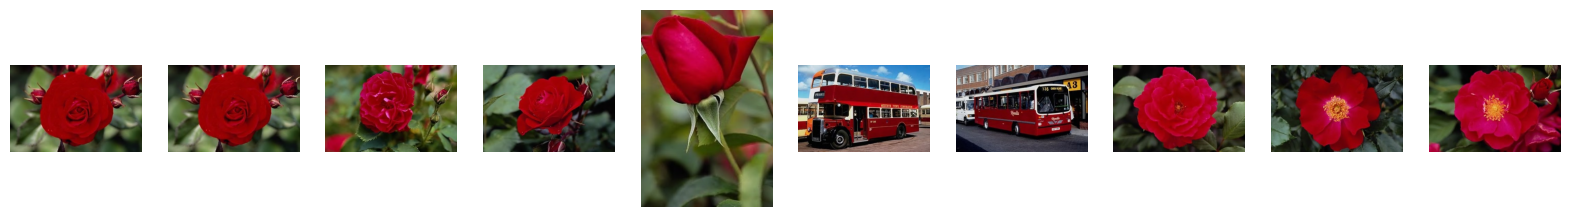

In [54]:
plt.figure(figsize=(20, 20))
for i, image in enumerate([query_image_360] + query_images_similar_images_360[0][:9]):
    plt.subplot(1, 10, 1 + i)
    plt.imshow(image)
    plt.axis('off')
plt.show()